In [0]:
from pydub import AudioSegment
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import pandas as pd
from sklearn.metrics import confusion_matrix
import keras
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Embedding
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, LSTM, Bidirectional
from keras.optimizers import sgd
import tensorflow as tf
import numpy as np
import itertools
import math
import time

In [1]:
!pip install librosa
!pip install pydub
!pip install pydrive

    100% |████████████████████████████████| 1.6MB 13.1MB/s 
    100% |████████████████████████████████| 327kB 26.7MB/s 
    100% |████████████████████████████████| 3.2MB 10.4MB/s 
    100% |████████████████████████████████| 16.1MB 2.1MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy
    100% |████████████████████████████████| 993kB 6.4MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
prueba = AudioSegment.from_wav("/content/drive/My Drive/prueba_test/302.wav")

In [0]:
#Compute spectogram of each audio

SR = 22050
def get_short_time_fourier_transform(soundwave):
    return librosa.stft(soundwave, n_fft=256)

def short_time_fourier_transform_amplitude_to_db(stft):
    return librosa.amplitude_to_db(stft)

def soundwave_to_np_spectogram(soundwave):
    step1 = get_short_time_fourier_transform(soundwave)
    step2 = short_time_fourier_transform_amplitude_to_db(step1)
    step3 = step2/100
    return step3

def inspect_data(sound):
#    plt.figure()
#    plt.plot(sound)
#    IPython.display.display(IPython.display.Audio(sound, rate=SR))
    a = get_short_time_fourier_transform(sound)
    Xdb = short_time_fourier_transform_amplitude_to_db(a)
#    plt.figure()   
#    plt.imshow(Xdb)    
#    plt.show()
#    print (Xdb.shape)
#    print("Length per sample: %d, shape of spectogram: %s, max: %f min: %f" % (len(sound), str(Xdb.shape), Xdb.max(), Xdb.min()))
    return Xdb

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
#Creacion de las variables necesarias para la ejecucion del codigo

i = 0
j = 0
k = 0
number_list_train = ['']
number_list_test = ['']
file_count = 107
file_count2 = 35
input_array_train = ['']
phq8_array_train = ['']
input_array_train *= file_count
phq8_array_train *= file_count
number_list_train *= file_count
input_array_test = ['']
phq8_array_test = ['']
input_array_test *= file_count2
phq8_array_test *= file_count2
number_list_test *= file_count2

In [0]:
#Abrir archivos de audio y segmentar por segmento de tiempo.
#Exportar los segmentos a otra carpeta para su posterior analisis


number = 0

l = 0
m = 0
      
data = open('C:/Users/Fran/Desktop/Database/datos1.txt', 'r', encoding='utf-8-sig')
for line in data:
    mylist = line.split(',')
    number = mylist[0]
    df = pd.read_csv('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' 
                     + str(number) + '_TRANSCRIPT.csv', header=0)
    while i < len (df):
        a = df.iloc[i].str.split()
        if a[0][2] == 'Participant' and j == 0: 
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba/' + str(number) + '.wav', format="wav")
            j = 1
        elif a[0][2] == 'Participant':
            
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba/' + str(number) + 'segmento.wav', format="wav")
            sound1 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba/' + str(number) + '.wav')
            sound2 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba/' + str(number) + 'segmento.wav')

            combined_sounds = sound1 + sound2
            combined_sounds.export('C:/Users/Fran/Desktop/prueba/' + str(number) + '.wav', format="wav")
        i += 1
             
    w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    input_array_train[l] = w
    number_list_train[l] = number
    phq8_array_train[l] = mylist[1]
    l += 1
    j = 0
    i = 0
    


In [0]:
#Abrir archivos de audio y segmentar por segmento de tiempo.
#Exportar los segmentos a otra carpeta para su posterior analisis

i = 0
l = 0
m = 0
data1 = open('C:/Users/Fran/Desktop/Database/datos2_dev.txt', 'r', encoding='utf-8-sig')
for line in data1:
    mylist = line.split(',')
    number = mylist[0]
    df = pd.read_csv('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' 
                     + str(number) + '_TRANSCRIPT.csv', header=0)
    while i < len (df):
        a = df.iloc[i].str.split()
        if a[0][2] == 'Participant' and j == 0: 
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba_test/' + str(number) + '.wav', format="wav")
            j = 1
        elif a[0][2] == 'Participant':
            
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba_test/' + str(number) + 'segmento.wav', format="wav")
            sound1 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba_test/' + str(number) + '.wav')
            sound2 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba_test/' + str(number) + 'segmento.wav')

            combined_sounds = sound1 + sound2
            combined_sounds.export('C:/Users/Fran/Desktop/prueba_test/' + str(number) + '.wav', format="wav")
        i += 1
             
    w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    input_array_test[l] = w
    number_list_test[l] = number
    phq8_array_test[l] = mylist[1]
    l += 1
    j = 0
    i = 0 

In [0]:
#creacion de arrays, que seran usados despues para el entranamiento del modelo y creacion de espectogramas

l = 0
data = open('/content/drive/My Drive/datos1.txt', 'r', encoding='utf-8-sig')
for line in data:
    mylist = line.split(',')
    number = mylist[0]
    #w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    #input_array_train[l] = w
    number_list_train[l] = number
    phq8_array_train[l] = mylist[1]
    l += 1
    
l = 0
data1 = open('/content/drive/My Drive/datos2_dev.txt', 'r', encoding='utf-8-sig')
for line in data1:
    mylist = line.split(',')
    number = mylist[0]
    #w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    #input_array_test[l] = w
    number_list_test[l] = number
    phq8_array_test[l] = mylist[1]
    l += 1

In [0]:
#Calculo de la longitud de cada audio para en un futuro poder mover la ventana de tiempo 
#del minimo al maximo unos determinados segundos, de momento esta informacion no se utiliza
#y se calcula el segmento de audio con un tiempo fijo

len_list_train = ['']
len_list_test = ['']
len_list_train *= file_count
len_list_test *= file_count2
i = 0
j = 0


for audio_number in number_list_train:
    Audio_train = AudioSegment.from_wav('/content/drive/My Drive/prueba/' + str(audio_number) + '.wav')
    len_list_train[i] = int(len(Audio_train) / (1000))
    i += 1
    
    
for audio_number in number_list_test:
    Audio_test = AudioSegment.from_wav('/content/drive/My Drive/prueba_test/' + str(audio_number) + '.wav')
    len_list_test[j] = int(len(Audio_test) / (1000))
    j += 1
    


In [0]:
t1_train_ini = 20 * 1000 + 1*1000
t1_train_ini

21000

In [0]:
#Creacion de los segmentos de audio para despues crear los espectogramas
#data augmentation segun el valor de la comparacion con la variable i de cada bucle while

t1_train_ini = 20 * 1000
t1_test_ini = 20 * 1000
t2_train_end = 20300
t2_test_end = 20300
i = 0
for audio_number in number_list_train:  
    i = 0
    while i<10:
        Audio_train = AudioSegment.from_wav('/content/drive/My Drive/prueba/' + str(audio_number) + '.wav')
        t1_train_ini_ = t1_train_ini + i*1000
        t2_train_end_ = t2_train_end + i*1000
        Audio_train = Audio_train[t1_train_ini_:t2_train_end_]
        Audio_train.export('/content/drive/My Drive/database_train/' + str(audio_number) + '_' + str(i) + '.wav', format="wav")
        i += 1
        time.sleep(1)
i = 0   
for audio_number in number_list_test:
    i = 0
    while i<10:
        Audio_test = AudioSegment.from_wav('/content/drive/My Drive/prueba_test/' + str(audio_number) + '.wav')
        t1_train_ini_ = t1_train_ini + i*1000
        t2_train_end_ = t2_train_end + i*1000
        Audio_test = Audio_test[t1_train_ini_:t2_train_end_]
        Audio_test.export('/content/drive/My Drive/database_test/' + str(audio_number) + '_' + str(i) + '.wav', format="wav")
        time.sleep(1)
        i += 1

In [10]:
#Spectograms of each segmented audio


Xdb_train = ['']
Xdb_train_normalized = ['']
Xdb_train *= file_count
Xdb_train_normalized *= file_count

Xdb_train *= 10

Xdb_test = ['']
Xdb_test_normalized = ['']
Xdb_test *= file_count2
Xdb_test_normalized *= file_count2

Xdb_test *= 10

i = 0
j = 0
for audio_train in number_list_train:
    j = 0
    while j<10:
        X, sr = librosa.load('/content/drive/My Drive/database_train/' + str(audio_train) + '_' + str(j) + '.wav')
        Xdb_train[i] = inspect_data(X)
        #Xdb_train_normalized[i] = tf.log(tf.abs(Xdb_train[i]) + 0.01)
        i += 1
        j += 1

i = 0
j = 0
for audio_test in number_list_test:
    j = 0
    while j<10:
        X, sr = librosa.load('/content/drive/My Drive/database_test/' + str(audio_test) + '_' + str(j) + '.wav')
        Xdb_test[i] = inspect_data(X)
        #Xdb_test_normalized[i] = tf.log(tf.abs(Xdb_test[i]) + 0.01)
        i += 1
        j += 1

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [40]:
np.shape(Xdb_test)

(350, 129, 104)

In [36]:
phq8_array_test[0:20]

['0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0']

In [0]:
#data augmentation para el valor a predecir

multiplier = 10
phq8_array_train_extended = ['']
phq8_array_train_extended = phq8_array_train_extended * file_count * multiplier
phq8_array_test_extended = ['']
phq8_array_test_extended = phq8_array_test_extended * file_count2 * multiplier
i = 0
j = 0
for valor in phq8_array_train:
    while i < multiplier:
        phq8_array_train_extended[j] = valor
        i += 1
        j += 1
    i = 0

i = 0
j = 0
for valor in phq8_array_test:
    while i < multiplier:
        phq8_array_test_extended[j] = valor
        i += 1
        j += 1
    i = 0

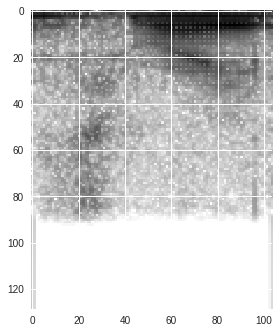

In [39]:
#Espectograma de 1 audio segmentado

plt.imshow(Xdb_train[0])
alto, ancho = np.shape(Xdb_train[0])

In [41]:
np.shape(Xdb_train)

(1070, 129, 104)

In [0]:
np.shape(Xdb_train_array)

(107, 1, 4515)

In [0]:
#Creacion de los arrays, transformand el array para introducirlo en la red LSTM

Xdb_train_array = np.ndarray(shape = (107*multiplier,alto,ancho))
Xdb_test_array = np.ndarray(shape = (35*multiplier,alto,ancho))

i = 0
for train in Xdb_train:
    Xdb_train_array[i] = train
    i += 1
    
i = 0
for test in Xdb_test:
    Xdb_test_array[i] = test
    i += 1
    
Xdb_train_array = Xdb_train_array.reshape(107*multiplier ,alto*ancho)
Xdb_test_array = Xdb_test_array.reshape(35*multiplier, alto*ancho)

Xdb_train_array = np.reshape(Xdb_train_array, (Xdb_train_array.shape[0], 1, Xdb_train_array.shape[1]))
Xdb_test_array = np.reshape(Xdb_test_array, (Xdb_test_array.shape[0], 1, Xdb_test_array.shape[1]))

In [0]:
#i= 0
#for audio_train in number_list_train:
#    Xdb_train[i] = Xdb_train[i].reshape(1333344,)
#    i += 1
    
#i= 0    
#for audio_test in number_list_test:
#    Xdb_test[i] = Xdb_test[i].reshape(1333344,)
#    i += 1

In [0]:
#Xdb_train_array=Xdb_train_array.reshape(Xdb_train_array.shape[0],Xdb_train_array.shape[1],1)

In [0]:
#Xdb_test_array=Xdb_test_array.reshape(Xdb_test_array.shape[0],Xdb_test_array.shape[1],1)

In [0]:
#np.shape(Xdb_train_array)

In [0]:
#num_classes = 2
#batch_size = 64
#epochs = 10

In [0]:
#Xdb_train_array = Xdb_train_array.reshape(Xdb_train_array.shape[0], alto, ancho, 1)
#Xdb_test_array = Xdb_test_array.reshape(Xdb_test_array.shape[0], alto, ancho, 1)

In [0]:
#print (Xdb_train_array.shape)
#print (Xdb_test_array.shape)

In [0]:
#seq = Sequential()
#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   input_shape=(107, 129, 1723, 1),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

#seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
#               activation='sigmoid',
#               padding='same', data_format='channels_last'))
#seq.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [0]:
#Red neuronal

#model = Sequential()
#model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(alto,ancho,1)))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(256, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='softmax'))

#model.summary()

#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.Adadelta(),
#              metrics=['accuracy'])

In [0]:
num_classes = 2
batch_size = 64
epochs = 10

# convert class vectors to binary class matrices
phq8_array_train = keras.utils.to_categorical(phq8_array_train_extended, num_classes)
phq8_array_test = keras.utils.to_categorical(phq8_array_test_extended, num_classes)

In [45]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True),
                        input_shape=(1, alto*ancho)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop(),
              metrics=['accuracy'])
#categorical_crossentropy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 256)            13870080  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 14,042,818
Trainable params: 14,042,818
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True,
               input_shape=(1, alto*ancho))))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(32, return_sequences=True)))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(32)))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.summary
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [67]:
model.fit(Xdb_train_array, phq8_array_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(Xdb_test_array, phq8_array_test))
score = model.evaluate(Xdb_test_array, phq8_array_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1070 samples, validate on 350 samples
Epoch 1/10
1070/1070 [==============================] - 8s 8ms/step - loss: 0.6134 - acc: 0.7196 - val_loss: 0.6432 - val_acc: 0.6571
Epoch 2/10
1070/1070 [==============================] - 3s 2ms/step - loss: 0.6009 - acc: 0.7196 - val_loss: 0.6447 - val_acc: 0.6571
Epoch 3/10
1070/1070 [==============================] - 3s 2ms/step - loss: 0.5955 - acc: 0.7196 - val_loss: 0.6480 - val_acc: 0.6571
Epoch 4/10
1070/1070 [==============================] - 3s 2ms/step - loss: 0.5939 - acc: 0.7196 - val_loss: 0.6499 - val_acc: 0.6571
Epoch 5/10
1070/1070 [==============================] - 3s 3ms/step - loss: 0.5939 - acc: 0.7196 - val_loss: 0.6518 - val_acc: 0.6571
Epoch 6/10
1070/1070 [==============================] - 3s 2ms/step - loss: 0.5937 - acc: 0.7196 - val_loss: 0.6522 - val_acc: 0.6571
Epoch 7/10
1070/1070 [==============================] - 3s 3ms/step - loss: 0.5939 - acc: 0.7196 - val_loss: 0.6523 - val_acc: 0.6571
Epoch 8/10
1070

In [47]:
np.shape(phq8_array_test)

(350, 2)

In [0]:
prediccion = model.predict(Xdb_test_array, batch_size=batch_size, verbose=1, steps=None)
for i in prediccion:
    print('Valor predicho:', i)

35/35 [==============================] - 3s 76ms/step
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7626601  0.23733997]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7613366  0.23866336]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7707407  0.22925933]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7606199  0.23938014]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7687864  0.23121361]
Valor predicho: [0.7606951 0.2393049]
Valor predicho: [0.7687864  

In [0]:
conf_matrix_pred = ['']
conf_matrix_pred *= 35
j = 0
for i in prediccion:
    conf_matrix_pred[j] = i.argmax(axis=0)
    print ("Clase: " + str(i.argmax(axis=0)))
    j += 1

Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0


In [0]:
conf_matrix_test = ['']
conf_matrix_test *= 35
j = 0
for i in phq8_array_test:
    conf_matrix_test[j] = i.argmax(axis=0)
    print ("Clase: " + str(i.argmax(axis=0)))
    j += 1

Clase: 0
Clase: 0
Clase: 0
Clase: 1
Clase: 1
Clase: 1
Clase: 1
Clase: 1
Clase: 0
Clase: 1
Clase: 1
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 1
Clase: 0
Clase: 1
Clase: 0
Clase: 1
Clase: 0
Clase: 0
Clase: 1
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 1
Clase: 0
Clase: 0
Clase: 0
Clase: 0


In [0]:
cnf_matrix = confusion_matrix(conf_matrix_test,conf_matrix_pred)

Confusion matrix, without normalization
[[23  0]
 [12  0]]


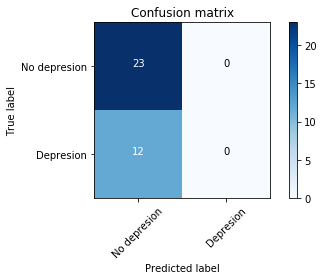

In [0]:
plot_confusion_matrix(cnf_matrix, classes=['No depresion','Depresion'],
                      title='Confusion matrix')